# Рассматриваем различные подходы к замеру эффекта в АБ-тестах

Рассматривать подходы будем на примере игрушечных примеров с длинами сессий по пользователям

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

## Генерация данных

In [3]:
from abtools import get_sales
from abtools import (
    check_ttest_naive,
    check_ttest_avg,
    check_bootstrap,
    check_poisson,
    check_delta_method,
    check_linearization,
    check_cuped,
    check_normed,
    check_normed_delta_method
)
from abtools import plot_pvalue_ecdf#, get_pvalue_samples

In [4]:
size = 5
# data_parameters = {
#     'effect': 0., 
#     's_cnt': (1, 6),
#     'mean_sales': 100, 
#     'sales_std': 20, 
#     'noise_std': 10,
#     'preperiod_effect': 0.
# }
real_data_parameters = {
    's_cnt': (4, 7), # В основном каждую из 6 недель есть хоть 1 продажа
    'mean_sales': 10, # Продажи невысокие
    'sales_std': 7, # А вот дисперсия, в среднем, равна продажам
    'noise_std': 4, # Шум внутри магазина поменьше
    's_cnt_before': (30, 45), # Препериод берём годовой
    'preperiod_effect': 0.01 # эффект небольшой
}
data_parameters = real_data_parameters

In [5]:
data_before, data = get_sales(size, **data_parameters)
display(data_before)
display(data)

[array([ 7., 19., 10.,  4.,  7., 11.,  7.,  7., 11.,  7.,  6., 10., 12.,
         9.,  9., 14.,  2.,  5.,  7.,  9.,  8.,  6.,  1., 15., 11.,  5.,
         3., 13., 21.,  7.,  4.,  5.,  8.,  4.,  5.,  8.,  1.,  6., 16.,
        10., 11.,  1.]),
 array([ 7.,  3.,  7., 11.,  5., 12.,  8., 11., 16.,  8., 13., 16.,  6.,
        10.,  7.,  7.,  5.,  7.,  8.,  8., 13.,  0., 13.,  6.,  8.,  1.,
        12., 15.,  7.,  9.,  6.,  4., 12.,  8.,  0.]),
 array([ 7., 13.,  9.,  3., 15.,  8., 13., 11.,  8., 12.,  9., 18.,  9.,
        20., 12.,  7.,  8., 11., 11., 12., 12., 20.,  5., 10.,  9., 10.,
         8.,  7.,  6., 11.]),
 array([14., 12., 14.,  8., 11., 20.,  8., 14., 14., 10.,  7., 13.,  9.,
        10., 11.,  9.,  8.,  8., 15., 10., 21.,  6., 14., 20.,  6., 11.,
         8.,  9.,  9.,  6., 12., 12., 11.]),
 array([13., 23., 17., 24., 14., 18., 20., 18., 18., 13., 16., 15., 12.,
        11., 19., 12., 22., 22., 17., 19., 21., 15., 17., 19., 14., 17.,
        19., 15., 19., 18., 16., 20., 22.]

[array([14., 12.,  3.,  5.]),
 array([11.,  6.,  5., 11., 10.]),
 array([10., 11., 14., 10.]),
 array([17., 12.,  9., 11.]),
 array([12., 19., 21., 23., 20., 20.])]

## Отрисовка распределения p-value

**Демонстрация, почему нехорошо брать магазино-дни.**

Распределение p-value при генерации выборок из нормального распределения должно быть равномерным

  0%|          | 0/1000 [00:00<?, ?it/s]

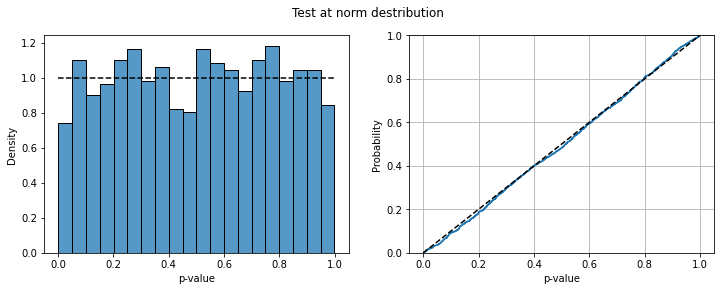

In [8]:
def get_pvalue_samples(a_sample_generator, b_sample_generator, size=1000):
    pvalues = []
    for _ in tqdm(range(size)):
        _, p = stats.ttest_ind(a_sample_generator(), b_sample_generator())
        pvalues.append(p)
    return pvalues
pvalues = get_pvalue_samples(
    a_sample_generator = lambda: np.random.normal(loc=100, scale=10, size=100),
    b_sample_generator = lambda: np.random.normal(loc=100, scale=10, size=100)
)
_ = plot_pvalue_ecdf(pvalues, title='Test at norm destribution')

А вот если мы начинаем брать продажи без разделения по магазинам (то есть все магазино-недели в 1 кучу), то тест уже невалиден.
Это происходит из-за того, что продажи одного магазина являются зависимыми.

  0%|          | 0/1000 [00:00<?, ?it/s]

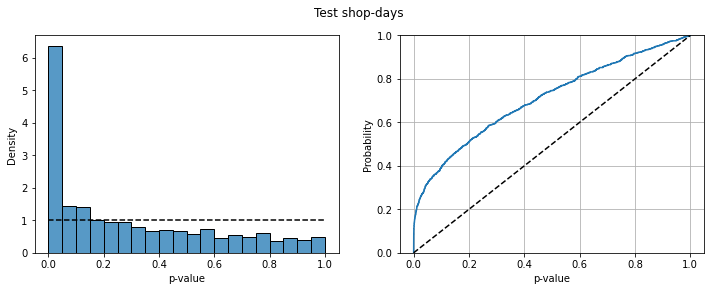

In [9]:
def get_naive_session_durations(size, effect=0.):
    def _durations():
        _, durations = get_sales(size, effect=effect, **data_parameters)
        return np.concatenate(durations)
    return _durations
pvalues = get_pvalue_samples(
    a_sample_generator = get_naive_session_durations(size=100),
    b_sample_generator = get_naive_session_durations(size=100),
)
_ = plot_pvalue_ecdf(pvalues, title='Test shop-days')

Если же мы агрегируем данные по магазинам, то тест становится валидным.

  0%|          | 0/1000 [00:00<?, ?it/s]

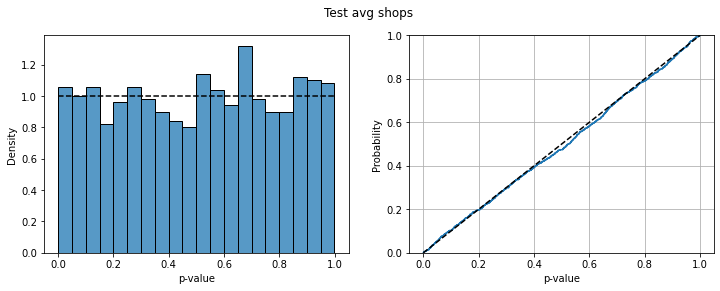

In [10]:
def get_avg_session_durations(size, effect=0.):
    def _durations():
        _, durations = get_sales(size, effect=effect, **data_parameters)
        return [u.mean() for u in durations]
    return _durations
pvalues = get_pvalue_samples(
    a_sample_generator = get_avg_session_durations(size=100),
    b_sample_generator = get_avg_session_durations(size=100),
)
_ = plot_pvalue_ecdf(pvalues, title='Test avg shops')

Если добавить в одну из групп эффект, то распределение становится выпуклым, что говорит о возможности уловить этот эффект. Правда, на таких шумных данных и эффект должен быть немалым.

  0%|          | 0/1000 [00:00<?, ?it/s]

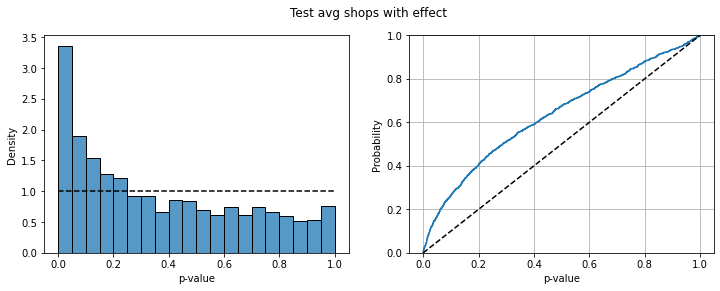

In [11]:
def get_avg_session_durations(size, effect=0.):
    def _durations():
        _, durations = get_sales(size, effect=effect, **data_parameters)
        return [u.mean() for u in durations]
    return _durations
pvalues = get_pvalue_samples(
    a_sample_generator = get_avg_session_durations(size=100),
    b_sample_generator = get_avg_session_durations(size=100, effect=0.1),
)
_ = plot_pvalue_ecdf(pvalues, title='Test avg shops with effect')

Если данные отнормировать на препериод, а затем усреднить в разрезе каждого магазина, то алгоритм так же работает корректно. Но нужно не забывать про усреднение, в противном случае получим взаимозависимость данных внутри магазина.

  0%|          | 0/1000 [00:00<?, ?it/s]

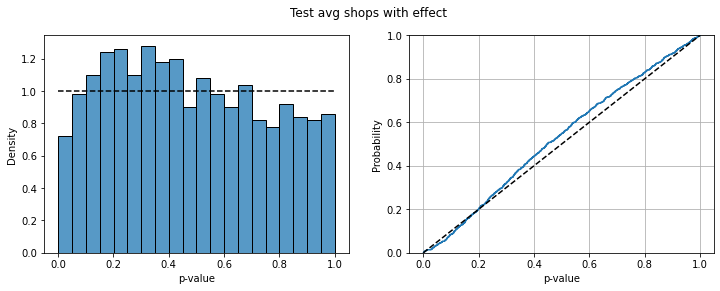

In [12]:
def get_normed_session_durations(size, effect=0.):
    def _durations():
        durations_before, durations = get_sales(size, effect=effect, **data_parameters)
        data = []
        for pp, p in zip(durations_before, durations):
#             data += list(p / pp.mean() - 1.)
            data.append((p / max(pp.mean(), 1/len(pp)) - 1.).mean())
        return data
    return _durations
pvalues = get_pvalue_samples(
    a_sample_generator = get_normed_session_durations(size=100),
    b_sample_generator = get_normed_session_durations(size=100, effect=0.00),
)
_ = plot_pvalue_ecdf(pvalues, title='Test avg shops with effect')

## Способы проверки гипотез без данных с препериода

In [7]:
from abtools import (
    check_ttest_naive,
    check_ttest_avg,
    check_bootstrap,
    check_poisson,
    check_delta_method,
    check_linearization
)

**Отрисовка сравнения всех методов**

In [21]:
dict_check = {
    'naive': check_ttest_naive,
    'avg': check_ttest_avg,
    'bootstrap': check_bootstrap,
    'poisson': check_poisson,
    'delta-method': check_delta_method,
    'linearization': check_linearization
}

res_dict = {key: {'pvalue': [], 'delta': []} for key in dict_check.keys()}
for _ in tqdm(range(200)):
    _, a = get_sales(100, **real_data_parameters)
#     _, b = get_sales(100)
    _, b = get_sales(100, effect = np.random.choice([0, -0.05, 0.05]), **data_parameters)
    
    for method_name, method in dict_check.items():
        pvalue, delta = method(a, b)
        res_dict[method_name]['pvalue'].append(pvalue)
        res_dict[method_name]['delta'].append(delta)

  0%|          | 0/200 [00:00<?, ?it/s]

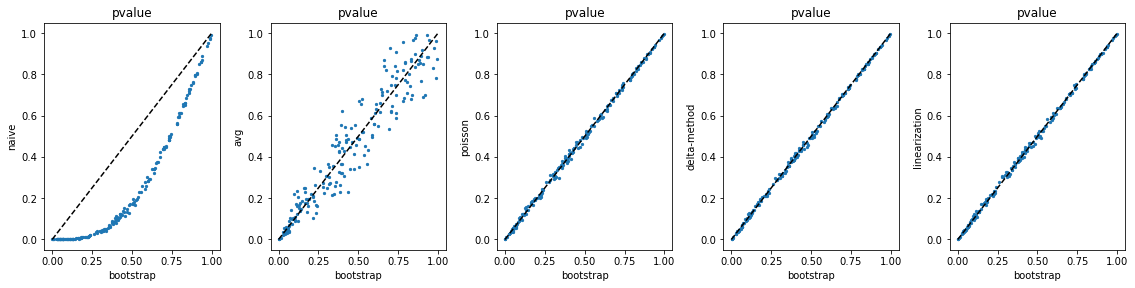

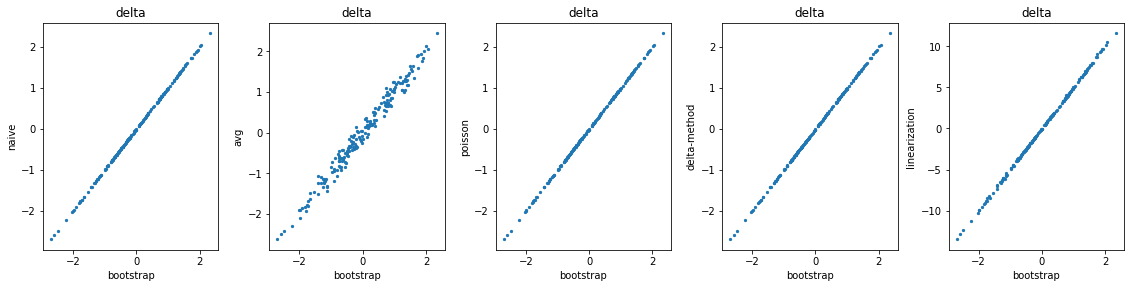

In [23]:
# За базовый метод возьмём бутстреп, так как он весьма точен и чувствителен
method_base_name = 'bootstrap'
pvalues_base = res_dict[method_base_name]['pvalue']
delta_base = res_dict[method_base_name]['delta']

for data_type in ['pvalue', 'delta']:
    fig, axes = plt.subplots(1, len(res_dict) - 1, figsize=(16, 4))
    fig.tight_layout(pad=2)
    
    plot_id = 0
    for key in res_dict:
        if key == method_base_name:
            continue
        
        axes[plot_id].scatter(res_dict[method_base_name][data_type], res_dict[key][data_type], s=5)
        
        if data_type == 'pvalue':
            axes[plot_id].plot([0, 1], [0, 1], 'k--')
        
        axes[plot_id].set_ylabel(key)
        axes[plot_id].set_xlabel(method_base_name)
        axes[plot_id].set_title(data_type)
        plot_id += 1
    
    plt.show()

Выводы по данным можно сделать следующие:
* Наивный алгоритм и бутстреп дают одинаковые значения метрики, но бутстреп является более чувствительным и с большей вероятностью отловит эффект. Поэтому бутстреп был принят за эталонный метод.
* Метод осреднения осреднения вообще весьма странный, выдаёт эффект практически случайно и метрика получается несонаправленной бутстрепу
* Пуассоновский бутстрап согласуется с результатами обычного
* Дельта метод несколько проигрывает бутстрепу в чувствительности, но при этом является намного более быстродейственным. Метрики при этом сонаправлены, поэтому выбирая между этими методами, лучше присмотреться именно к дельта-методу
* Метод линеаризации даёт хорошую чувствительность и сонаправленную метрику. Сложность заключается в том, что отсутствует понимание того, что конкретно за метрику считает метод линеаризации.

## Способы проверки гипотез с данными с препериода

In [24]:
from abtools import check_cuped, check_normed, check_normed_delta_method

In [25]:
data_parameters = real_data_parameters
data_parameters

{'s_cnt': (4, 7),
 'mean_sales': 10,
 'sales_std': 7,
 'noise_std': 4,
 's_cnt_before': (30, 45),
 'preperiod_effect': 0.01}

In [17]:
# data_parameters = {
#     's_cnt': (4, 7),
#     'mean_sales': 10,
#     'sales_std': 5,
#     'noise_std': 2,
#     'preperiod_effect': 0.01
# }

In [26]:
size = 300 # У нас где-то по 100 магазинов в группе
effect = 0.1

np.random.seed(23)

data_pilot_before, data_pilot = get_sales(size, effect=effect, **data_parameters)
data_control_before, data_control = get_sales(size, effect=0., **data_parameters)

In [29]:
dict_check = {
    'naive': lambda a, a_before, b, b_before: check_ttest_naive(a, b),
    'avg': lambda a, a_before, b, b_before: check_ttest_avg(a, b),
    'bootstrap': lambda a, a_before, b, b_before: check_bootstrap(a, b),
    'poisson': lambda a, a_before, b, b_before: check_poisson(a, b),
    'delta-method': lambda a, a_before, b, b_before: check_delta_method(a, b),
    'linearization': lambda a, a_before, b, b_before: check_linearization(a, b),
    'cuped': check_cuped,
    'normed': check_normed,
    'normed_delta': check_normed_delta_method
}

print(f"Заложенный эффект: {effect:.3f} ({data_parameters['mean_sales'] * effect} шт)")
effect_mean = np.concatenate(data_pilot).mean() - np.concatenate(data_control).mean()
effect_mean_rate = effect_mean / np.concatenate(data_control).mean()
print(f"Точечный эффект пилота: {effect_mean_rate:.3f} ({effect_mean:.3f} шт)")

pilot_dynamics = (1 + effect) / (1 - data_parameters['preperiod_effect'])
control_dynamics = 1 / (1 - data_parameters['preperiod_effect'])
print(f'Заложенный эффект в динамику {pilot_dynamics - control_dynamics:.3f}')
pilot_dynamics = np.concatenate(data_pilot).mean() / np.concatenate(data_pilot_before).mean()
control_dynamics = np.concatenate(data_control).mean() / np.concatenate(data_control_before).mean()
print(f"Точечный эффект в динамику пилота: {pilot_dynamics - control_dynamics:.3f}")
print()

for m_name, method in dict_check.items():
    p, d = method(data_control, data_control_before, data_pilot, data_pilot_before)
    print(f'p-value: {p:.4f}, delta: {d:.4f}, method: {m_name}')

Заложенный эффект: 0.100 (1.0 шт)
Точечный эффект пилота: 0.069 (0.724 шт)
Заложенный эффект в динамику 0.101
Точечный эффект в динамику пилота: 0.094

p-value: 0.0069, delta: 0.7237, method: naive
p-value: 0.1839, delta: 0.7112, method: avg
p-value: 0.1774, delta: 0.7237, method: bootstrap
p-value: 0.1661, delta: 0.7237, method: poisson
p-value: 0.1813, delta: 0.7237, method: delta-method
p-value: 0.1867, delta: 3.5558, method: linearization
p-value: 0.0000, delta: 4.7665, method: cuped
p-value: 0.7831, delta: 0.0157, method: normed
p-value: 0.5099, delta: 0.0320, method: normed_delta


**Получаем, что только CUPED получает шансы отловить хоть какой-то эффект. Нормализация и Ниромализация с дельта-методом не могут отловить даже 20% эффект. На более приемлемых данных эти методы работают лучше.**

**Равномерность p-value**

  0%|          | 0/4000 [00:00<?, ?it/s]

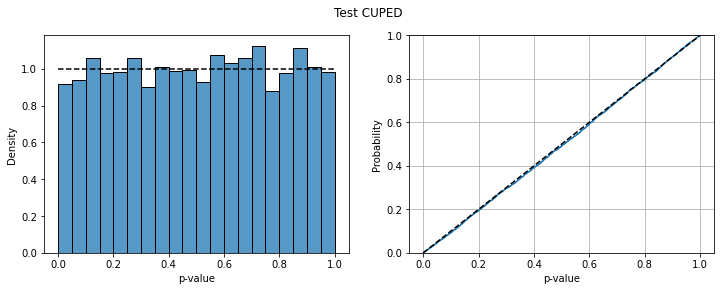

In [26]:
size = 100 # У нас где-то по 100 магазинов в группе
effect = 0.00

pvalues = []
for _ in tqdm(range(4000)):
    data_pilot_before, data_pilot = get_sales(size, effect=effect, **real_data_parameters)
    data_control_before, data_control = get_sales(size, effect=0., **real_data_parameters)
    
    pvalue, _ = check_cuped(data_control, data_control_before, data_pilot, data_pilot_before)
    pvalues.append(pvalue)

_ = plot_pvalue_ecdf(pvalues, title='Test CUPED')

  0%|          | 0/4000 [00:00<?, ?it/s]

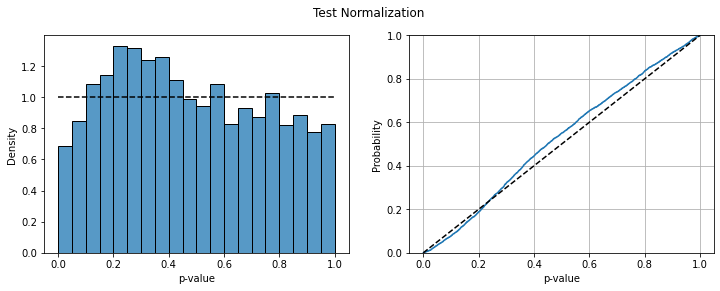

In [27]:
pvalues = []
for _ in tqdm(range(4000)):
    data_pilot_before, data_pilot = get_sales(size, effect=effect, **real_data_parameters)
    data_control_before, data_control = get_sales(size, effect=0., **real_data_parameters)
    
    pvalue, _ = check_normed(data_control, data_control_before, data_pilot, data_pilot_before)
    pvalues.append(pvalue)

_ = plot_pvalue_ecdf(pvalues, title='Test Normalization')

  0%|          | 0/4000 [00:00<?, ?it/s]

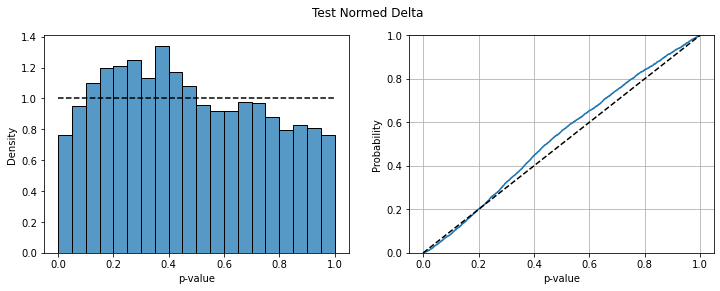

In [29]:
pvalues = []
for _ in tqdm(range(4000)):
    data_pilot_before, data_pilot = get_sales(size, effect=effect, **real_data_parameters)
    data_control_before, data_control = get_sales(size, effect=0., **real_data_parameters)
    
    pvalue, _ = check_normed_delta_method(data_control, data_control_before, data_pilot, data_pilot_before)
    pvalues.append(pvalue)

_ = plot_pvalue_ecdf(pvalues, title='Test Normed Delta')

**Дельта-метод работает в целом не хуже среднего-средних, но у него должно быть получше с сонаправленностью.**